# Fault Analysis of AUX converters

### 1. Load and Prepare Data

In [2]:
import pandas as pd
pd.set_option("display.max_rows", None)



file_path = "sample_data.xlsx"



df = pd.read_excel(file_path, skiprows=3)



df.head()

,Field Name,Units,2024-12-26 17:39:40,2024-12-26 17:39:41,2024-12-26 17:39:42,2024-12-26 17:39:43,2024-12-26 17:39:44,2024-12-26 17:39:45,2024-12-26 17:39:45.1,2024-12-26 17:39:46,2024-12-26 17:39:47,2024-12-26 17:39:48
0,Packet_Index,NaN,0,0,0,0,0,0,24,0,0,0
1,Loco_speed,KMPH,0,0,0,0,0,0,0,0,0,0
2,Acceleration,m/sec2,0,0,0,0,0,0,0,0,0,0
3,OHE_Volt_KV,KV,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2
4,OHE_Current,Amps,0,0,0,0,0,0,0,0,0,0


### Step 2. Cleanup the code (omit all string valued rows)

In [3]:
# Omit all rows where they have only string values in the columns C-L

df = df[df.iloc[:, 2:12].map(pd.api.types.is_number).any(axis=1)].reset_index(
    drop=True
)

df.head()

,Field Name,Units,2024-12-26 17:39:40,2024-12-26 17:39:41,2024-12-26 17:39:42,2024-12-26 17:39:43,2024-12-26 17:39:44,2024-12-26 17:39:45,2024-12-26 17:39:45.1,2024-12-26 17:39:46,2024-12-26 17:39:47,2024-12-26 17:39:48
0,Packet_Index,NaN,0,0,0,0,0,0,24,0,0,0
1,Loco_speed,KMPH,0,0,0,0,0,0,0,0,0,0
2,Acceleration,m/sec2,0,0,0,0,0,0,0,0,0,0
3,OHE_Volt_KV,KV,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2
4,OHE_Current,Amps,0,0,0,0,0,0,0,0,0,0


### Step 3. Skip rows where values remained the same during before and after cases

In [4]:

def before_after_equal(row):
    before = row.iloc[2:7].values  # Get 'before' values
    after = row.iloc[7:12].values  # Get 'after' values
    return (before == after).all()  # Compare


# Apply the filter to remove rows where before == after
df = df[~df.apply(before_after_equal, axis=1)].reset_index(drop=True)
df.head()

,Field Name,Units,2024-12-26 17:39:40,2024-12-26 17:39:41,2024-12-26 17:39:42,2024-12-26 17:39:43,2024-12-26 17:39:44,2024-12-26 17:39:45,2024-12-26 17:39:45.1,2024-12-26 17:39:46,2024-12-26 17:39:47,2024-12-26 17:39:48
0,Packet_Index,NaN,0,0,0,0,0,0,24,0,0,0
1,Bogie1_DCLV,Volts,577,573,563,557,560,559,550,554,538,545
2,Bogie2_DCLV,Volts,572,576,554,575,559,551,550,561,546,542
3,Aux_Winding_I,Amps,11,11,12,12,14,11,12,9,11,12
4,Bogie1_T_F_Oil_Temp,Deg c,48,48,48,48,48,48,48,48,49,48


### Step 3.1 Further cleaning of NaN, NUM unit values

In [5]:
# Remove rows where the "Units" column is NaN or equals "NUM"
if "Units" in df.columns:
    df = df[~(df["Units"].isna() | (df["Units"] == "NUM"))].reset_index(drop=True)
df.head()

,Field Name,Units,2024-12-26 17:39:40,2024-12-26 17:39:41,2024-12-26 17:39:42,2024-12-26 17:39:43,2024-12-26 17:39:44,2024-12-26 17:39:45,2024-12-26 17:39:45.1,2024-12-26 17:39:46,2024-12-26 17:39:47,2024-12-26 17:39:48
0,Bogie1_DCLV,Volts,577,573,563,557,560,559,550,554,538,545
1,Bogie2_DCLV,Volts,572,576,554,575,559,551,550,561,546,542
2,Aux_Winding_I,Amps,11,11,12,12,14,11,12,9,11,12
3,Bogie1_T_F_Oil_Temp,Deg c,48,48,48,48,48,48,48,48,49,48
4,VCU1_DIP_Temp,Deg c,36,36,37,36,37,37,36,36,36,37


### Step 4. Calculate the mean values of before and after values

In [6]:
# Calculate mean of columns C-G as 'before' and H-L as 'after' using the dataframe df


# Calculate mean values
df_means = df.iloc[:, :2].copy()  # Copy identifier columns
df_means["before"] = df.iloc[:, 2:7].mean(axis=1)
df_means["after"] = df.iloc[:, 7:12].mean(axis=1)

# Output to check
df_means.head()

,Field Name,Units,before,after
0,Bogie1_DCLV,Volts,566.0,549.2
1,Bogie2_DCLV,Volts,567.2,550.0
2,Aux_Winding_I,Amps,12.0,11.0
3,Bogie1_T_F_Oil_Temp,Deg c,48.0,48.2
4,VCU1_DIP_Temp,Deg c,36.4,36.4


### Step 5. Calculating absolute % changes of mean values

In [7]:
# Calculate absolute percentage change, avoid division by zero
before_nonzero = df_means["before"].replace(0, pd.NA)
df_means["%_change"] = ((df_means["after"] - df_means["before"]).abs() / before_nonzero.abs()) * 100

# Output the identifier columns, before, after, and percentage change for all rows
df_means[df_means.columns[:2].tolist() + ["before", "after", "%_change"]]
df_means.head()

,Field Name,Units,before,after,%_change
0,Bogie1_DCLV,Volts,566.0,549.2,2.968198
1,Bogie2_DCLV,Volts,567.2,550.0,3.03244
2,Aux_Winding_I,Amps,12.0,11.0,8.333333
3,Bogie1_T_F_Oil_Temp,Deg c,48.0,48.2,0.416667
4,VCU1_DIP_Temp,Deg c,36.4,36.4,0.0


### Step 6. Apply threshold to filter significant changes

In [8]:
threshold = 10
df_means_filtered = df_means[df_means["%_change"] > threshold].reset_index(drop=True)
df_means_filtered[df_means_filtered.columns[:2].tolist() + ["before", "after", "%_change"]]

,Field Name,Units,before,after,%_change
0,TM1_I_Peak,Amps,6.0,6.8,13.333333
1,TM3_I_Peak,Amps,5.0,5.8,16.0
2,TM4_I_Peak,Amps,4.0,4.8,20.0
3,TM5_I_Peak,Amps,4.0,5.0,25.0
4,Aux_CurrentLC3,Amps,10.98,7.9,28.051002
5,AC2_DCLI,Amps,0.6,1.0,66.666667
6,LC1__Is_Rms_With_Ripple,Amps,1.7,1.5,11.764706
7,LC2_IsPeak,Amps,8.1,7.22,10.864198
8,LC4_IpPeak,Amps,2.34,2.62,11.965812


### Step 7. Plot the results as bargraphs

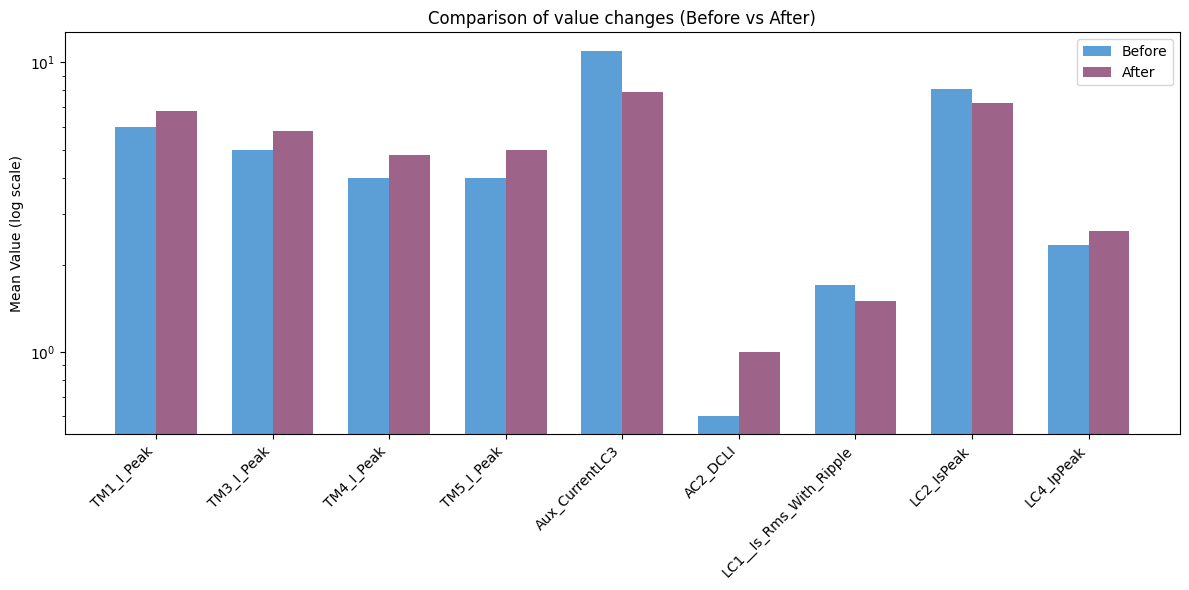

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
labels = df_means_filtered[df_means_filtered.columns[0]]  # Field name column
before = df_means_filtered["before"]
after = df_means_filtered["after"]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
# Use pale colors for bars
rects1 = ax.bar(x - width/2, before, width, label='Before', color="#5b9fd6")
rects2 = ax.bar(x + width/2, after, width, label='After', color="#9e6389")

ax.set_yscale('log')
ax.set_ylabel('Mean Value (log scale)')
ax.set_title('Comparison of value changes (Before vs After)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

### Step 8. Plot the results as a line plot

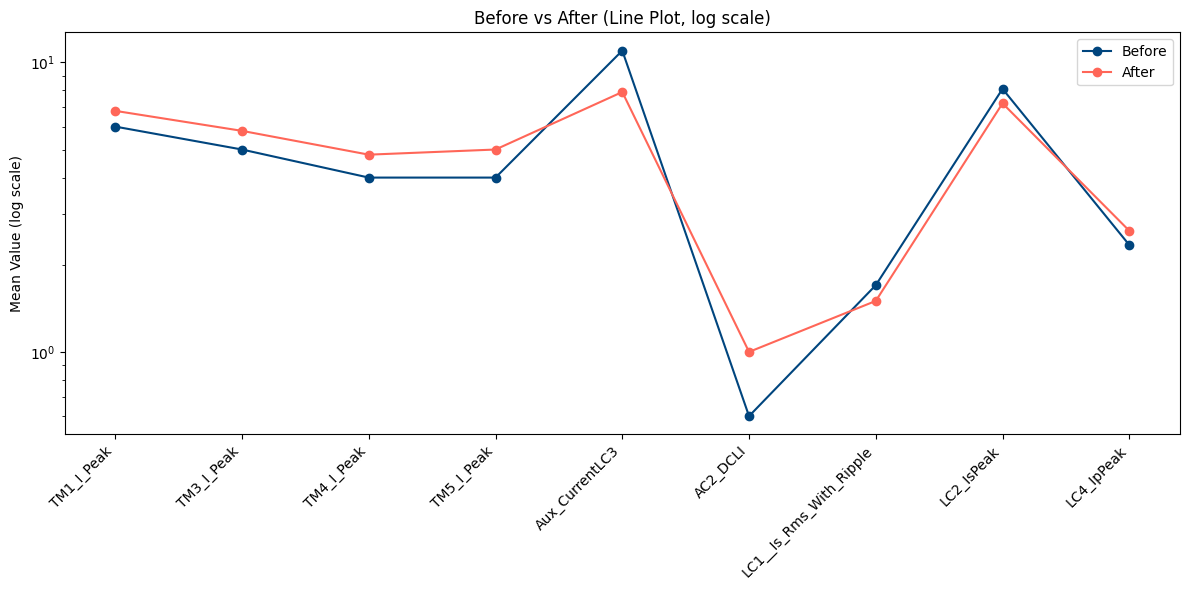

In [13]:
import matplotlib.pyplot as plt

labels = df_means_filtered[df_means_filtered.columns[0]]
before = df_means_filtered["before"]
after = df_means_filtered["after"]

plt.figure(figsize=(12, 6))
plt.plot(labels, before, marker='o', linestyle='-', label='Before', color="#00457e")
plt.plot(labels, after, marker='o', linestyle='-', label='After', color="#ff6658")
plt.yscale('log')
plt.ylabel('Mean Value (log scale)')
plt.title('Before vs After (Line Plot, log scale)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### Step 9. Plot the percentage change as a horizontal bar plot

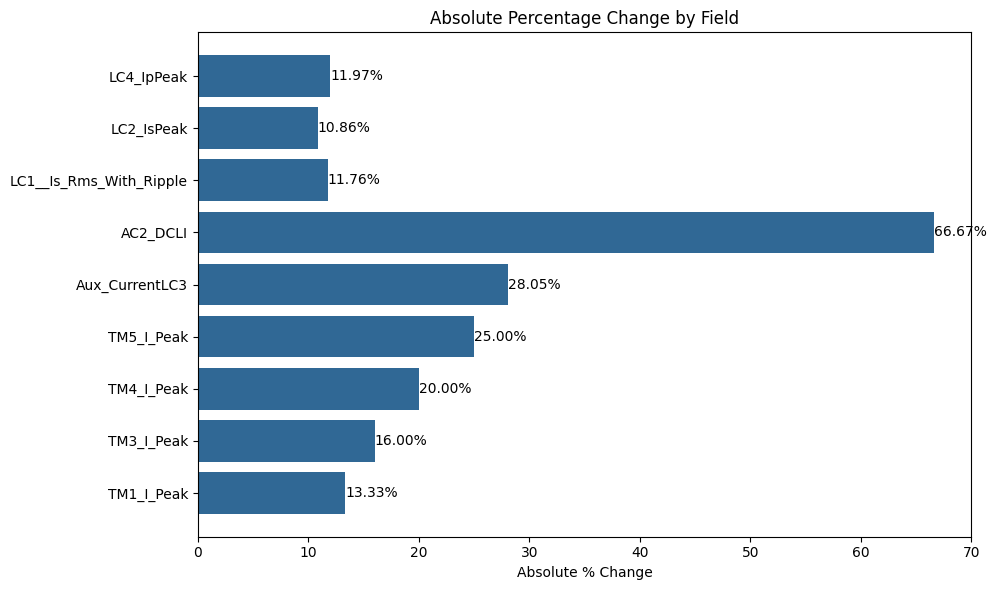

In [19]:
import matplotlib.pyplot as plt

labels = df_means_filtered[df_means_filtered.columns[0]]
pct_change = df_means_filtered["%_change"]

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, pct_change, color="#00457dcf")
plt.xlabel("Absolute % Change")
plt.title("Absolute Percentage Change by Field")
plt.tight_layout()

for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}%",
        va="center",
        ha="left",
    )

plt.show()